In [287]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import pickle

In [255]:
df = pd.read_csv("insurance.csv")

In [256]:
df.shape

(1338, 7)

In [257]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [259]:
x = df.drop(columns = ["charges"])
y = df["charges"]

In [260]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.20, random_state = 36)

all_train = pd.concat([x_train,y_train], axis = 1)

Now EDA only on x_train

In [261]:
x_train.shape

(1070, 6)

In [262]:
x_train.head()

,age,sex,bmi,children,smoker,region
620,30,male,31.400,1,no,southwest
500,29,male,34.400,0,yes,southwest
1093,22,female,30.400,0,yes,northwest
649,58,female,32.965,0,no,northeast
319,32,male,37.335,1,no,northeast


In [263]:
x_train.describe()

,age,bmi,children
count,1070.000000,1070.000000,1070.000000
mean,38.916822,30.737243,1.080374
std,14.073162,6.153841,1.194424
min,18.000000,15.960000,0.000000
25%,26.000000,26.237500,0.000000
50%,39.000000,30.500000,1.000000
75%,51.000000,34.800000,2.000000
max,64.000000,53.130000,5.000000


In [264]:
print(x_train["region"].unique())
print(x_train["smoker"].unique())

['southwest' 'northwest' 'northeast' 'southeast']
['no' 'yes']


In [265]:
x_train["sex"] = x_train["sex"].map({"male": 1, "female": 0})
x_test["sex"] = x_test["sex"].map({"male": 1, "female": 0})
x["sex"] = x["sex"].map({"male": 1, "female": 0})
all_train["sex"] = all_train["sex"].map({"male": 1, "female": 0})

x_train["smoker"] = x_train["smoker"].map({"yes": 1, "no": 0})
x_test["smoker"] = x_test["smoker"].map({"yes": 1, "no": 0})
x["smoker"] = x["smoker"].map({"yes": 1, "no": 0})
all_train["smoker"] = all_train["smoker"].map({"yes": 1, "no": 0})

In [266]:
x_train.head()

,age,sex,bmi,children,smoker,region
620,30,1,31.400,1,0,southwest
500,29,1,34.400,0,1,southwest
1093,22,0,30.400,0,1,northwest
649,58,0,32.965,0,0,northeast
319,32,1,37.335,1,0,northeast


In [267]:
correlation = all_train.corr(numeric_only = True)

correlation

,age,sex,bmi,children,smoker,charges
age,1.000000,-0.023166,0.094175,0.044474,-0.014822,0.304674
sex,-0.023166,1.000000,0.062887,0.032627,0.077542,0.062413
bmi,0.094175,0.062887,1.000000,0.000124,-0.006231,0.182822
children,0.044474,0.032627,0.000124,1.000000,0.012241,0.070805
smoker,-0.014822,0.077542,-0.006231,0.012241,1.000000,0.788156
charges,0.304674,0.062413,0.182822,0.070805,0.788156,1.000000


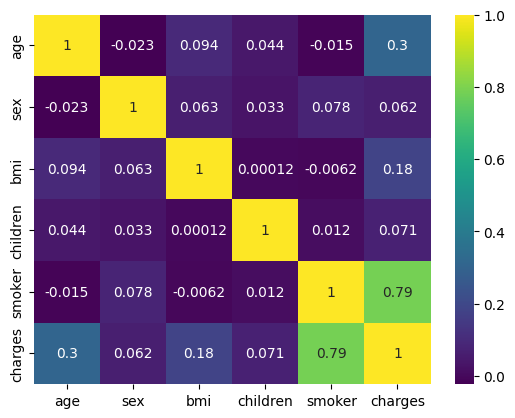

In [268]:
sns.heatmap(correlation, annot = True, cmap = "viridis")
plt.show()

In [269]:
corr_order = correlation["charges"].sort_values()

In [270]:
corr_order

sex         0.062413
children    0.070805
bmi         0.182822
age         0.304674
smoker      0.788156
charges     1.000000
Name: charges, dtype: float64

In [271]:
encoder = OneHotEncoder(sparse_output = False)
encoding = encoder.fit_transform(x_train[["region"]])
encoded = pd.DataFrame(encoding, columns = encoder.get_feature_names_out(["region"]), index = x_train.index)

x_train = x_train.drop(columns = ["region"])
x_train = pd.concat([x_train, encoded], axis = 1)

#x_test

x_test_encoding = encoder.transform(x_test[["region"]])
x_test_encoded = pd.DataFrame(x_test_encoding, columns = encoder.get_feature_names_out(["region"]), index = x_test.index)

x_test = x_test.drop(columns = ["region"])
x_test = pd.concat([x_test, x_test_encoded], axis = 1)


In [272]:
x_train.shape

(1070, 9)

In [273]:
x_train.head()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
620,30,1,31.400,1,0,0.0,0.0,0.0,1.0
500,29,1,34.400,0,1,0.0,0.0,0.0,1.0
1093,22,0,30.400,0,1,0.0,1.0,0.0,0.0
649,58,0,32.965,0,0,1.0,0.0,0.0,0.0
319,32,1,37.335,1,0,1.0,0.0,0.0,0.0


In [274]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [275]:
def evaluate_model(model):

    model.fit(x_train,y_train)

    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)

    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    mse = mean_squared_error(y_test, test_pred)
    mae = mean_absolute_error(y_test, test_pred)

    print(f"r2 score (train data): {r2_train}")
    print(f"r2 score (test data): {r2_test}")
    print(f"Mean squared error (test data): {mse}")
    print(f"Mean absolute error (test data): {mae}")
    print("\n")

    plt.title("Predicted vs Actual (Test Data)")
    plt.scatter(y_test, test_pred, color = "green")
    plt.plot(y_test, y_test, color = "red")
    plt.show()

r2 score (train data): 0.7503999592339173
r2 score (test data): 0.7497802218717132
Mean squared error (test data): 28823702.88962357
Mean absolute error (test data): 3695.1829150276635




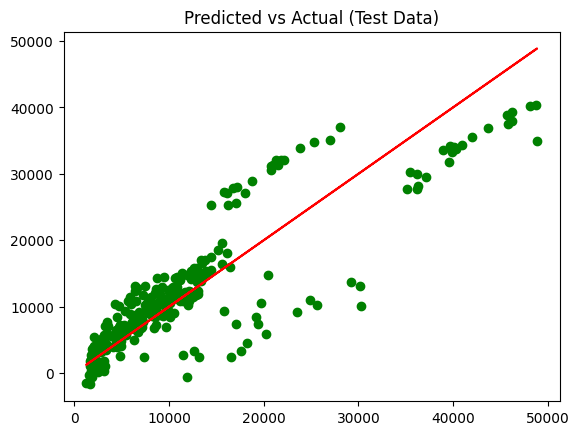

In [276]:
evaluate_model(LinearRegression())

r2 score (train data): 0.7192108266740369
r2 score (test data): 0.7183002364029447
Mean squared error (test data): 32449993.964249346
Mean absolute error (test data): 3065.6257926243925




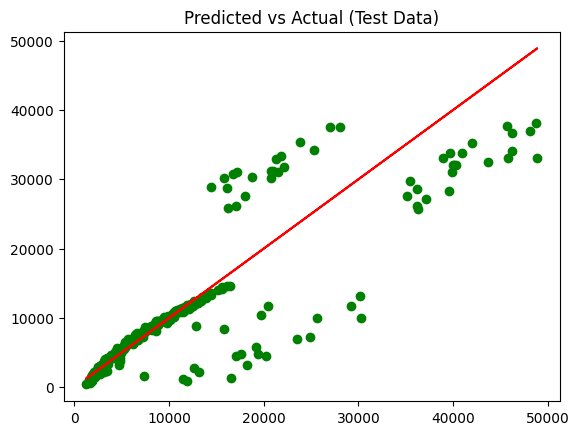

In [277]:
evaluate_model(SVR(kernel = "linear", gamma = "scale", C = 200, epsilon = 0.1))

r2 score (train data): 0.8718953732800016
r2 score (test data): 0.840043235342573
Mean squared error (test data): 18425986.523364697
Mean absolute error (test data): 2630.04102176222




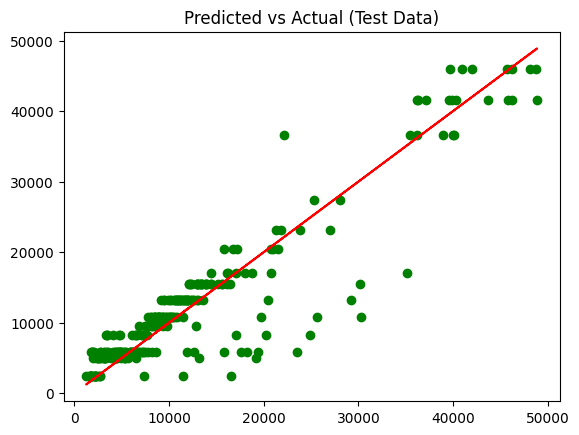

In [278]:
evaluate_model(DecisionTreeRegressor(criterion = "squared_error", max_depth = 4, random_state = 36))

r2 score (train data): 0.8659973605806724
r2 score (test data): 0.8483418404429469
Mean squared error (test data): 17470040.795969564
Mean absolute error (test data): 2521.252672249435




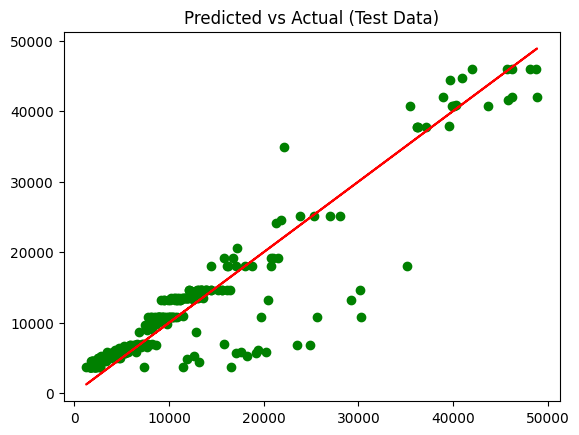

In [279]:
evaluate_model(RandomForestRegressor(n_estimators = 1000, criterion = "squared_error", max_depth = 3, min_samples_split = 5, random_state = 36))

r2 score (train data): 0.8844494835322138
r2 score (test data): 0.8634147863642154
Mean squared error (test data): 15733734.744721843
Mean absolute error (test data): 2349.8365586833024




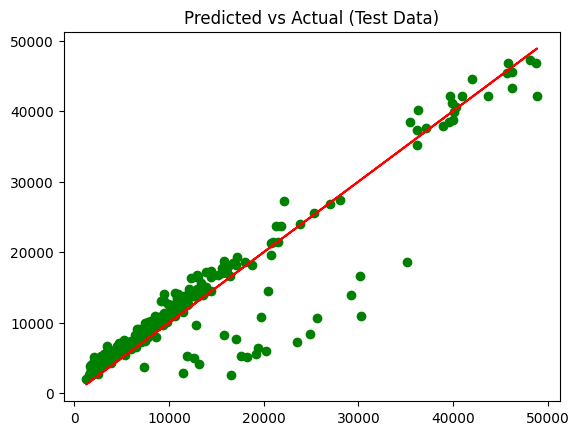

In [280]:
evaluate_model(XGBRegressor(objective = "reg:squarederror", n_estimators = 100, max_depth = 3, learning_rate = 0.05, random_state = 36))

For 5 models used, XGBoost Regressor gets highest accuracy (r2 score of test data: 0.8634, Mean squared error of 15733734.744). So XGBoost Regressor is choosing for the final model

In [281]:
x.head()

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,southwest
1,18,1,33.770,1,0,southeast
2,28,1,33.000,3,0,southeast
3,33,1,22.705,0,0,northwest
4,32,1,28.880,0,0,northwest


In [282]:
x.shape

(1338, 6)

In [283]:
final_encoder = OneHotEncoder(sparse_output = False)
x_encoding = final_encoder.fit_transform(x[["region"]])
x_encoded = pd.DataFrame(x_encoding, columns = final_encoder.get_feature_names_out(["region"]), index = x.index)

x = x.drop(columns = ["region"])
x = pd.concat([x, x_encoded], axis = 1)

In [284]:
x.head()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,0.0,1.0,0.0,0.0


In [285]:
final_scaler = StandardScaler()
x = final_scaler.fit_transform(x)

In [286]:
final_model = XGBRegressor(objective = "reg:squarederror", n_estimators = 100, max_depth = 3, learning_rate = 0.05, random_state = 36)
final_model.fit(x,y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [288]:
with open("encoder.pkl", "wb") as f:
    pickle.dump(final_encoder, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(final_scaler, f)

with open("model.pkl", "wb") as f:
    pickle.dump(final_model, f)